# Recitation 11

This week we'll do something a bit different. This notebook is meant to be a review of numpy, however most people learn how to use numpy for a different reason, machine learning, it wouldn't do justice to the library if we skip that now would it?

<img src="https://media.tenor.com/Vz-Vjh01PTYAAAAM/is-it-ai-ai.gif" alt="meme" width="200"/>

## A Brief Primer

What we'll be doing today is an extremely simplified version of a "fully connected neural network." Neural networks are pretty self explanatory (they're networks of neurons), however what is a neuron exactly? Well that's simple too, a neuron is just a weight that you multiply to some vector, in other words it's a simple function. Some very smart people in the 90s figured out that by layering this neurons on top of one another you can learn really precise details about your datasets and even learn "non-linear" featured, thus this method of learning was dubbed "deep learning". Alas that little intro doesn't do the subject nearly enough justice, so I'd recommend watching some videos on youtube so that you can learn from people way smarter than myself.

## Data Setup

We'll start by using the famous mnist dataset that we'll convert into binary values 0 or 1 to make our life easier. These libraries come pre installed on colab, however please install them on your machine if you need them. The Binarized MNIST dataset here are digits from 0-9 in a 20x16 pixel grid, instructions on how to visualize them is provided below.

For now use x and Y arrays without splitting into test/train where x are the actual features and y are the labels. If you are unfamiliar with test/train splits I'd recommend looking that up and being comfortable with the subject.

In [11]:
!curl -L  https://cs.nyu.edu/~roweis/data/binaryalphadigs.mat --output binaryalphadigs.mat

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  519k  100  519k    0     0  1359k      0 --:--:-- --:--:-- --:--:-- 1357k


In [73]:
import scipy.io
import numpy as np

x = []
Y = []

data = scipy.io.loadmat('binaryalphadigs.mat')
for i in range(10):
      label = data['classlabels'][0][i].item()
      for j in range(len(data['dat'][i])):
        image = data['dat'][i][j].reshape(20, 16, 1)
        image = np.array(image)
        reshaped_image = np.reshape(image, (20, 16))
        x.append(reshaped_image)
        Y.append(int(label))

9


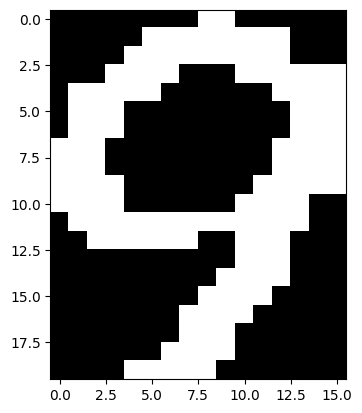

In [74]:
import matplotlib.pyplot as plt

plt.imshow(x[389], cmap='gray', interpolation='nearest')
print(Y[389])

## Our First Problem!

Though we have our 390 images of binarized digits from 0-9, how am I supposed to work with a two dimensional image?!? Think of other "regression" problems such as predicting house prices or test scores. We always get the features of an item as a "vector" and not as a matrix. This is because classifying a matrix is non-trivial.

*An Aside* While there is absolutely a way we can classify these two dimensional matrix images directly, these are called convolutional neural networks, that's way beyond the scope of this class. However you're welcome to look into the subject in your own time.

Therefore we now need to take our matrix inputs and convert them into vector inputs, if only there was an easy way to "flatten" all of our matrices... however we need to make them columns not rows so after flattening we can flip them

In [105]:
flattned_x = [matrix.flatten().reshape(1, -1) for matrix in x]
flattened_x = np.array(flattned_x)

On that note we also need to convert our labels which are digits from 0-9 into a one hot encoding that look like the following:

0 -> [1, 0, 0, 0, ...]

...

9-> [..., 1]

In [101]:
one_hot_encoding = np.eye(10) # NOTE: Look into why this line is useful
one_hot_array = np.array(one_hot_encoding)

one_hot_Y = np.array([one_hot_array[i] for i in Y])

## The Architecture

Just like designing a house, a strong data scientist designs the best model for their needs. Different business needs would dictate different model designs, however in an effort to keep this task simple we will work with the bare minimum.

We'll build a neural network model with three layers, an input, a hidden, and an output layer. Each layer will have a certain inputs and outputs, any guesses what the inputs of the first and the outputs of the final layer will be??

**Input Layer** Here we simply take each pixel value from our digit input... that's literally it there's no math in this part. Our input layer is going to be a 1x320 input since there are 320 pixels in total.

**W1** The weights in between the layers take the values from each neuron (there are 320 neurons in the first layer) and multiply it with some set of weights that we learn iteratively. The result of this matrix multiplication needs to be the size of the hidden layer.

**Hidden Layer** It's called a hidden layer because, well it's hidden! After multiplying the first layer by the weights I want to be left with 120 neurons or values in this layer for each image. This means that the weights combine certain pixel values together in some smart way that we don't really need to worry about.

**W2** A second set of weights need to transform the 120 neurons of the hidden layer into exactly 10 values

**Output Layer** There are exactly 10 possibilities for out image, this layer should consist of 10 values which should be the probabilities/likelihoods of the given digits from 0-9.

**Non Linearity** You'll also see that we use a sigmoid function below, this helps us understand the nonlinear relationship between the pixels and its class much better. The important part for now is understanding how to implement it, please look into why it's important in your own time. Without non linearity what we're doing simply becomes your good ole fashioned linear regression

<img src="https://raw.githubusercontent.com/Codecademy/docs/main/media/sigmoid-function.png" alt="meme" width="400"/>

If this was a bit too much to understand please ask your TA for help!

In [77]:
# Creating the Feed forward neural network
# 1 Input layer(1, 320)
# 1 hidden layer (1, 120)
# 1 output layer(1, 10)

def sigmoid(x):
    return(1/(1 + np.exp(-x)))

def f_forward(x, w1, w2):
    # hidden
    z1 = x.dot(w1)# input from layer 1
    a1 = sigmoid(z1)# output of layer 2

    # Output layer
    z2 = a1.dot(w2)# input of out layer
    a2 = sigmoid(z2)# output of out layer
    return(a2)

# The weights are the super important part, however at the start we can just
# assign them random values since we don't know what they'll be
def generate_wt(x, y):
    l =[]
    for i in range(x * y):
        l.append(np.random.randn())
    return(np.array(l).reshape(x, y))

## Loss

A loss function tells our model how well it has done in predicting classes, in our case it tells the model how well it has classified our digits into 0-9. To keep things simple we use the Mean Square Error loss, basically we look at the distance between our prediction and label and take the square of it then mean of all the values to figure out how good/bad our model is

In [78]:
def loss(out, Y):
    s =(np.square(out-Y))
    s = np.sum(s)/len(Y)
    return(s)

## Backpropogation

Understanding back propogation is the key to understanding how neural networks learn. Therefore, I've used the help of my handy AI friend to help explain.

Imagine you're playing a video game, and your goal is to get the highest score. Now, let's say after each game, your friend gives you feedback on your performance. They point out where you made mistakes and suggest how you can improve.

Backpropagation in the world of computers is a bit like that feedback process for a computer learning how to do a task, such as recognizing pictures of cats and dogs.

Here's how it works:

1. **Making Predictions:**
   - Just like you're trying to predict the best moves in the game, a computer model makes predictions based on the input it gets. For example, it looks at a vector and tries to decide if it's a 0 or a 5.

2. **Comparing Predictions to Reality:**
   - After making a prediction, the computer checks it against the correct answer (like checking if you correctly identified the picture). If it got it wrong, it needs to figure out what went wrong.

3. **Calculating Mistakes (Loss):**
   - The computer calculates how far off its prediction was from the correct answer using the loss function we talked about earlier. This is like your friend giving you a score after each game.

4. **Adjusting to Improve:**
   - Now comes the cool part, backpropagation! The computer looks at the mistakes it made and figures out how it can adjust its "strategies" to do better next time. It's like you learning from your mistakes and trying a different approach in the game.

5. **Updating the Model:**
   - The computer updates its weights based on the mistakes it made. It's like tweaking the way it makes decisions so that it gets closer to the correct answer the next time.

6. **Repeating the Process:**
   - The computer repeats this process over and over. Each time it plays a "game" (makes predictions on a set of data), it learns from its mistakes and gets better.

So, backpropagation is like a computer learning from its errors, adjusting its approach, and getting smarter and more accurate over time just like you do when playing a video game and trying to improve your score!

The way it improves is by tweaking the weights repeatedly until it has reached some local maxima at which point it proclaims that it has done the best it can! This process is called gradient descent since we calculate the gradient of the given input and follow that gradient by taking steps until we reach the optimum value for the weights.

At the end of the day, all we want to learn is the best way that we can transform a vector of 320 into a vector of 10.

In [79]:
def back_prop(x, Y, w1, w2, alpha):

    # hidden layer
    z1 = x.dot(w1)# input from layer 1
    a1 = sigmoid(z1)# output of layer 2

    # Output layer
    z2 = a1.dot(w2)# input of out layer
    a2 = sigmoid(z2)# output of out layer

    # error in output layer
    d2 =(a2-Y)

    # The weights for the hidden layer are the more complex part, spend some time trying to
    # understand this code basically we try to figure out how much error each neuron
    # in the hidden layer is responsible for

    # The second part is to make sure that we correctly identify both it being a certain
    # class and also NOT being a certain class, the first is the assignment of blame,
    # your TA will go into more detail
    d1 = np.multiply((w2.dot((d2.transpose()))).transpose(), (np.multiply(a1, 1-a1)))

    # Gradient for w1 and w2
    w1_adj = x.transpose().dot(d1)
    w2_adj = a1.transpose().dot(d2)

    # Updating parameters
    w1 = w1-(alpha*(w1_adj))
    w2 = w2-(alpha*(w2_adj))

    return(w1, w2)

## Wrapping Up

We finally need to bring it all together, let's write a train function, we set a limit for how many iterations we want to try to train our model (epochs)

In [111]:
def train(x, Y, w1, w2, alpha = 0.01, epoch = 10):
    acc =[]
    losss =[]
    for j in range(epoch):
        l =[]
        for i in range(len(x)):
            out = f_forward(x[i], w1, w2)
            l.append((loss(out, Y[i])))
            w1, w2 = back_prop(x[i], Y[i], w1, w2, alpha)
        print("epochs:", j + 1, "======== acc:", (1-(sum(l)/len(x)))*100)
        acc.append((1-(sum(l)/len(x)))*100)
        losss.append(sum(l)/len(x))
    return(acc, losss, w1, w2)

def predict(x, w1, w2):
    Out = f_forward(x, w1, w2)
    maxm = 0
    k = 0
    for i in range(len(Out[0])):
        if(maxm < Out[0][i]):
            maxm = Out[0][i]
            k = i
    print(k)
    plt.imshow(x.reshape(20, 16), cmap='gray', interpolation='nearest')
    plt.show()

In [117]:
w1 = generate_wt(320, 120)
w2 = generate_wt(120, 10)

acc, losss, w1, w2 = train(flattened_x, one_hot_Y, w1, w2, 0.1)

epochs: 1 ======== acc: 97.98068816727906
epochs: 2 ======== acc: 98.7395418515099
epochs: 3 ======== acc: 99.14729848939221
epochs: 4 ======== acc: 99.40902321814347
epochs: 5 ======== acc: 99.55458427888809
epochs: 6 ======== acc: 99.64894206408991
epochs: 7 ======== acc: 99.7402402768996
epochs: 8 ======== acc: 99.82838381688326
epochs: 9 ======== acc: 99.867182373644
epochs: 10 ======== acc: 99.89899991050717


8


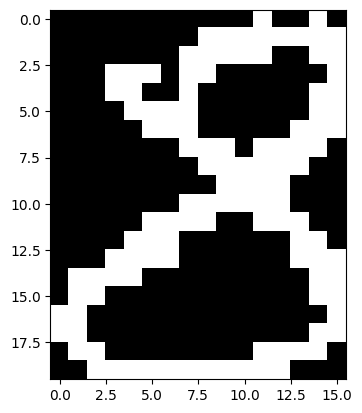

In [114]:
predict(flattened_x[320], w1, w2)

## Credits

Most of this code was taken from here: https://www.geeksforgeeks.org/implementation-of-neural-network-from-scratch-using-numpy/